In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy

import tensorflow as tf

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [54]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Multi-Class Classification /Train.csv')
df.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [55]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [56]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [57]:
class Data_Preprocessing:
  def __init__(self,df,target_feature = None):
    self.df = df
    self.target_feature = target_feature

  def _feature_target_split(self):
    if self.target_feature != None:
      X = self.df[[feature for feature in self.df.columns if feature != self.target_feature]]
      y = self.df[self.target_feature]
      return X,y

    else:
      X = self.df
      return X

  def _one_hot(self,X):
    ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output = False).set_output(transform = 'pandas')

    return ohe.fit_transform(X)

    return X

  def _normalize(self,X):
    X = normalize(X)
    return X


  def transform(self):
    if self.target_feature != None:
      numerical_features = eda.numerical_features()
      numerical_features = list(numerical_features)
      numerical_features.remove(self.target_feature)
      numerical_features = np.array(numerical_features)

      categorical_features = eda.categorical_features()

      X,y = self._feature_target_split()
      X,y = X.fillna(value = 0),y.fillna(value = 'Nan')

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X,y

    else:
      numerical_features = [column for column in self.df.columns if self.df[column].dtype != 'O']
      categorical_features = eda.categorical_features()

      X = self._feature_target_split()
      X = X.fillna(value = 0)

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X

In [58]:
class Segmentation(tf.keras.Model):
  def __init__(self,n_classes):
    super().__init__()
    self.n_classes = n_classes

    self.linear_1 = tf.keras.layers.Dense(64)
    self.linear_2 = tf.keras.layers.Dense(128)
    self.linear_3 = tf.keras.layers.Dense(256)
    self.linear_4 = tf.keras.layers.Dense(512)
    self.linear_5 = tf.keras.layers.Dense(n_classes)

    self.sigmoid = tf.keras.activations.sigmoid
    self.softmax = tf.keras.activations.softmax

  def call(self,X):
    X = self.linear_1(X)
    X = self.sigmoid(X)

    X = self.linear_2(X)
    X = self.sigmoid(X)

    X = self.linear_3(X)
    X = self.sigmoid(X)

    X = self.linear_4(X)
    X = self.sigmoid(X)

    X = self.linear_5(X)


    return X

In [59]:
class Train_Model:
  def __init__(self,model,batch_size = 32,epochs = 10):
    self.model = model
    self.batch_size = batch_size
    self.epochs = epochs


    self._fit_model = None

  def fit(self,X,y):
    self.model = model

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
        )

    print(f'\nMetrics on Train Data:')
    model.fit(X,y,batch_size = self.batch_size,epochs = self.epochs)
    self._fit_model = model

    return model

  def eval(self,X,y):
    model = self._fit_model
    
    print(f'\nMetrics on Test Data:')
    model.evaluate(X,y)

In [60]:
def Predict(model,X):
  predictions = model.predict(X)
  predictions = tf.argmax(predictions,1)

  labels = [inverse_vocab[int(prediction)] for prediction in predictions]

  return np.array(labels)

In [61]:
target_feature = 'Segmentation'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature = target_feature)
data_preprocessing = Data_Preprocessing(df,target_feature = target_feature)

In [62]:
labels = list(eda.unique_values(target_feature))

vocab = {label: label_idx for label_idx,label in enumerate(labels)}
inverse_vocab = {label_idx: label for label,label_idx in vocab.items()}

Unique values of Segmentation: ['A' 'B' 'C' 'D']


In [63]:
for label,label_idx in vocab.items():
  print(f'Label: {label} | Label idx: {label_idx}')
  df[target_feature] = df[target_feature].replace(to_replace = label, value = label_idx)

Label: A | Label idx: 0
Label: B | Label idx: 1
Label: C | Label idx: 2
Label: D | Label idx: 3


In [64]:
eda.shape()

Number of samples in Data Set: 8068
Number of columns: 11


(8068, 11)

In [65]:
eda.unique_columns()

Unique columns:

Column 1: ID
Column 2: Gender
Column 3: Ever_Married
Column 4: Age
Column 5: Graduated
Column 6: Profession
Column 7: Work_Experience
Column 8: Spending_Score
Column 9: Family_Size
Column 10: Var_1
Column 11: Segmentation


Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [66]:
eda.columns_dtypes()

Dtypes:

 ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation         int64
dtype: object


ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation         int64
dtype: object

In [67]:
eda.categorical_features()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ tre

array(['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Var_1'], dtype='<U14')

In [68]:
eda.numerical_features()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

array(['ID', 'Age', 'Work_Experience', 'Family_Size', 'Segmentation'],
      dtype='<U15')

In [69]:
eda.count_NA()

Amout of Nans per class:


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [70]:
eda.duplicates()

Amount of duplicates: 0


In [71]:
eda.unique_values(target_feature)

Unique values of Segmentation: [0 1 2 3]


array([0, 1, 2, 3])

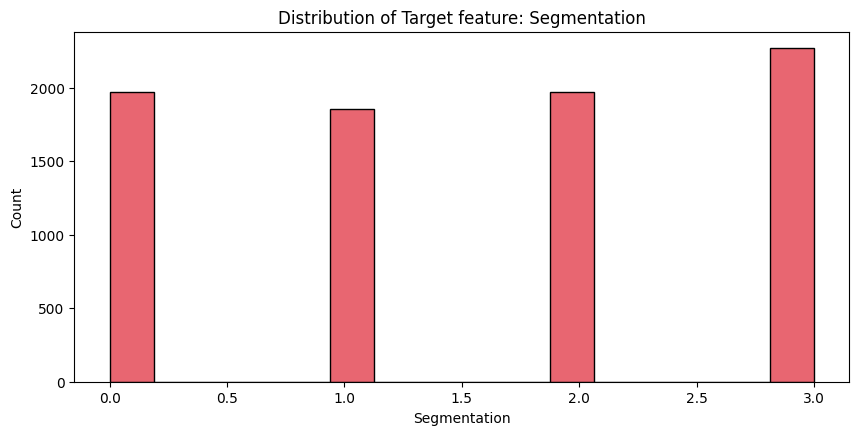

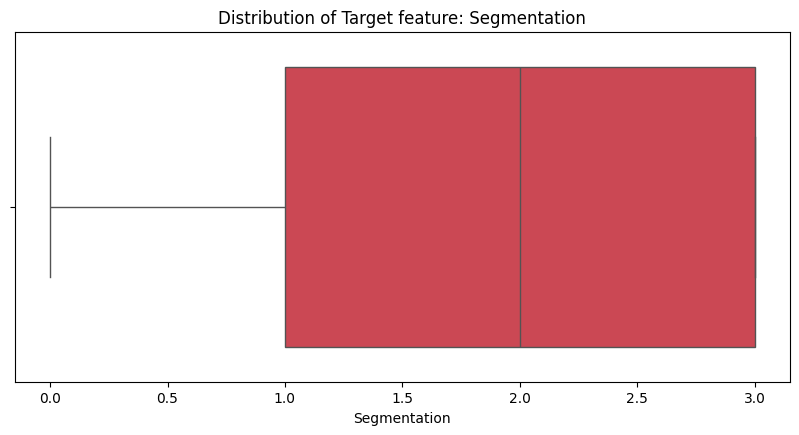

In [72]:
data_visualization.distribution_of_target_feature()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

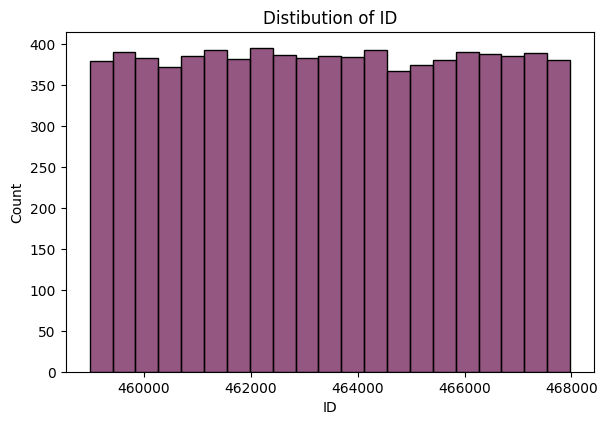

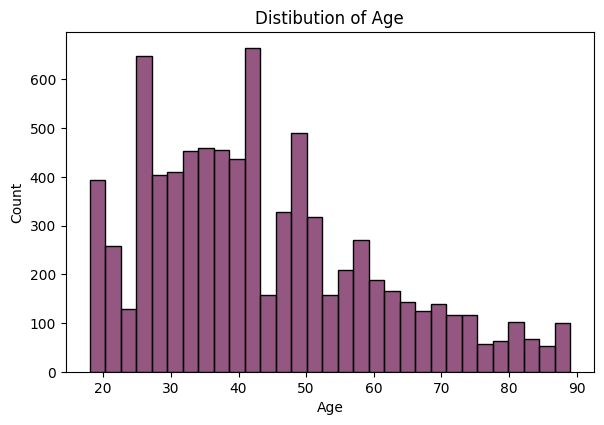

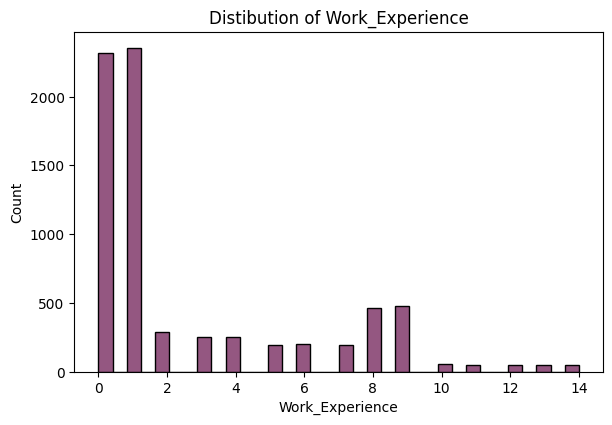

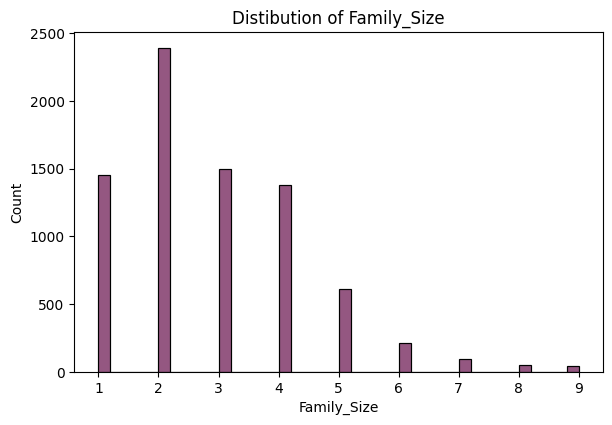

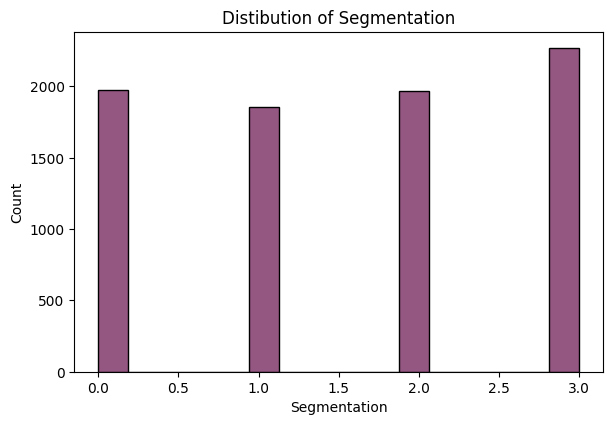

In [73]:
data_visualization.distribution_of_numerical_features()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gende

/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ tre

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ tre

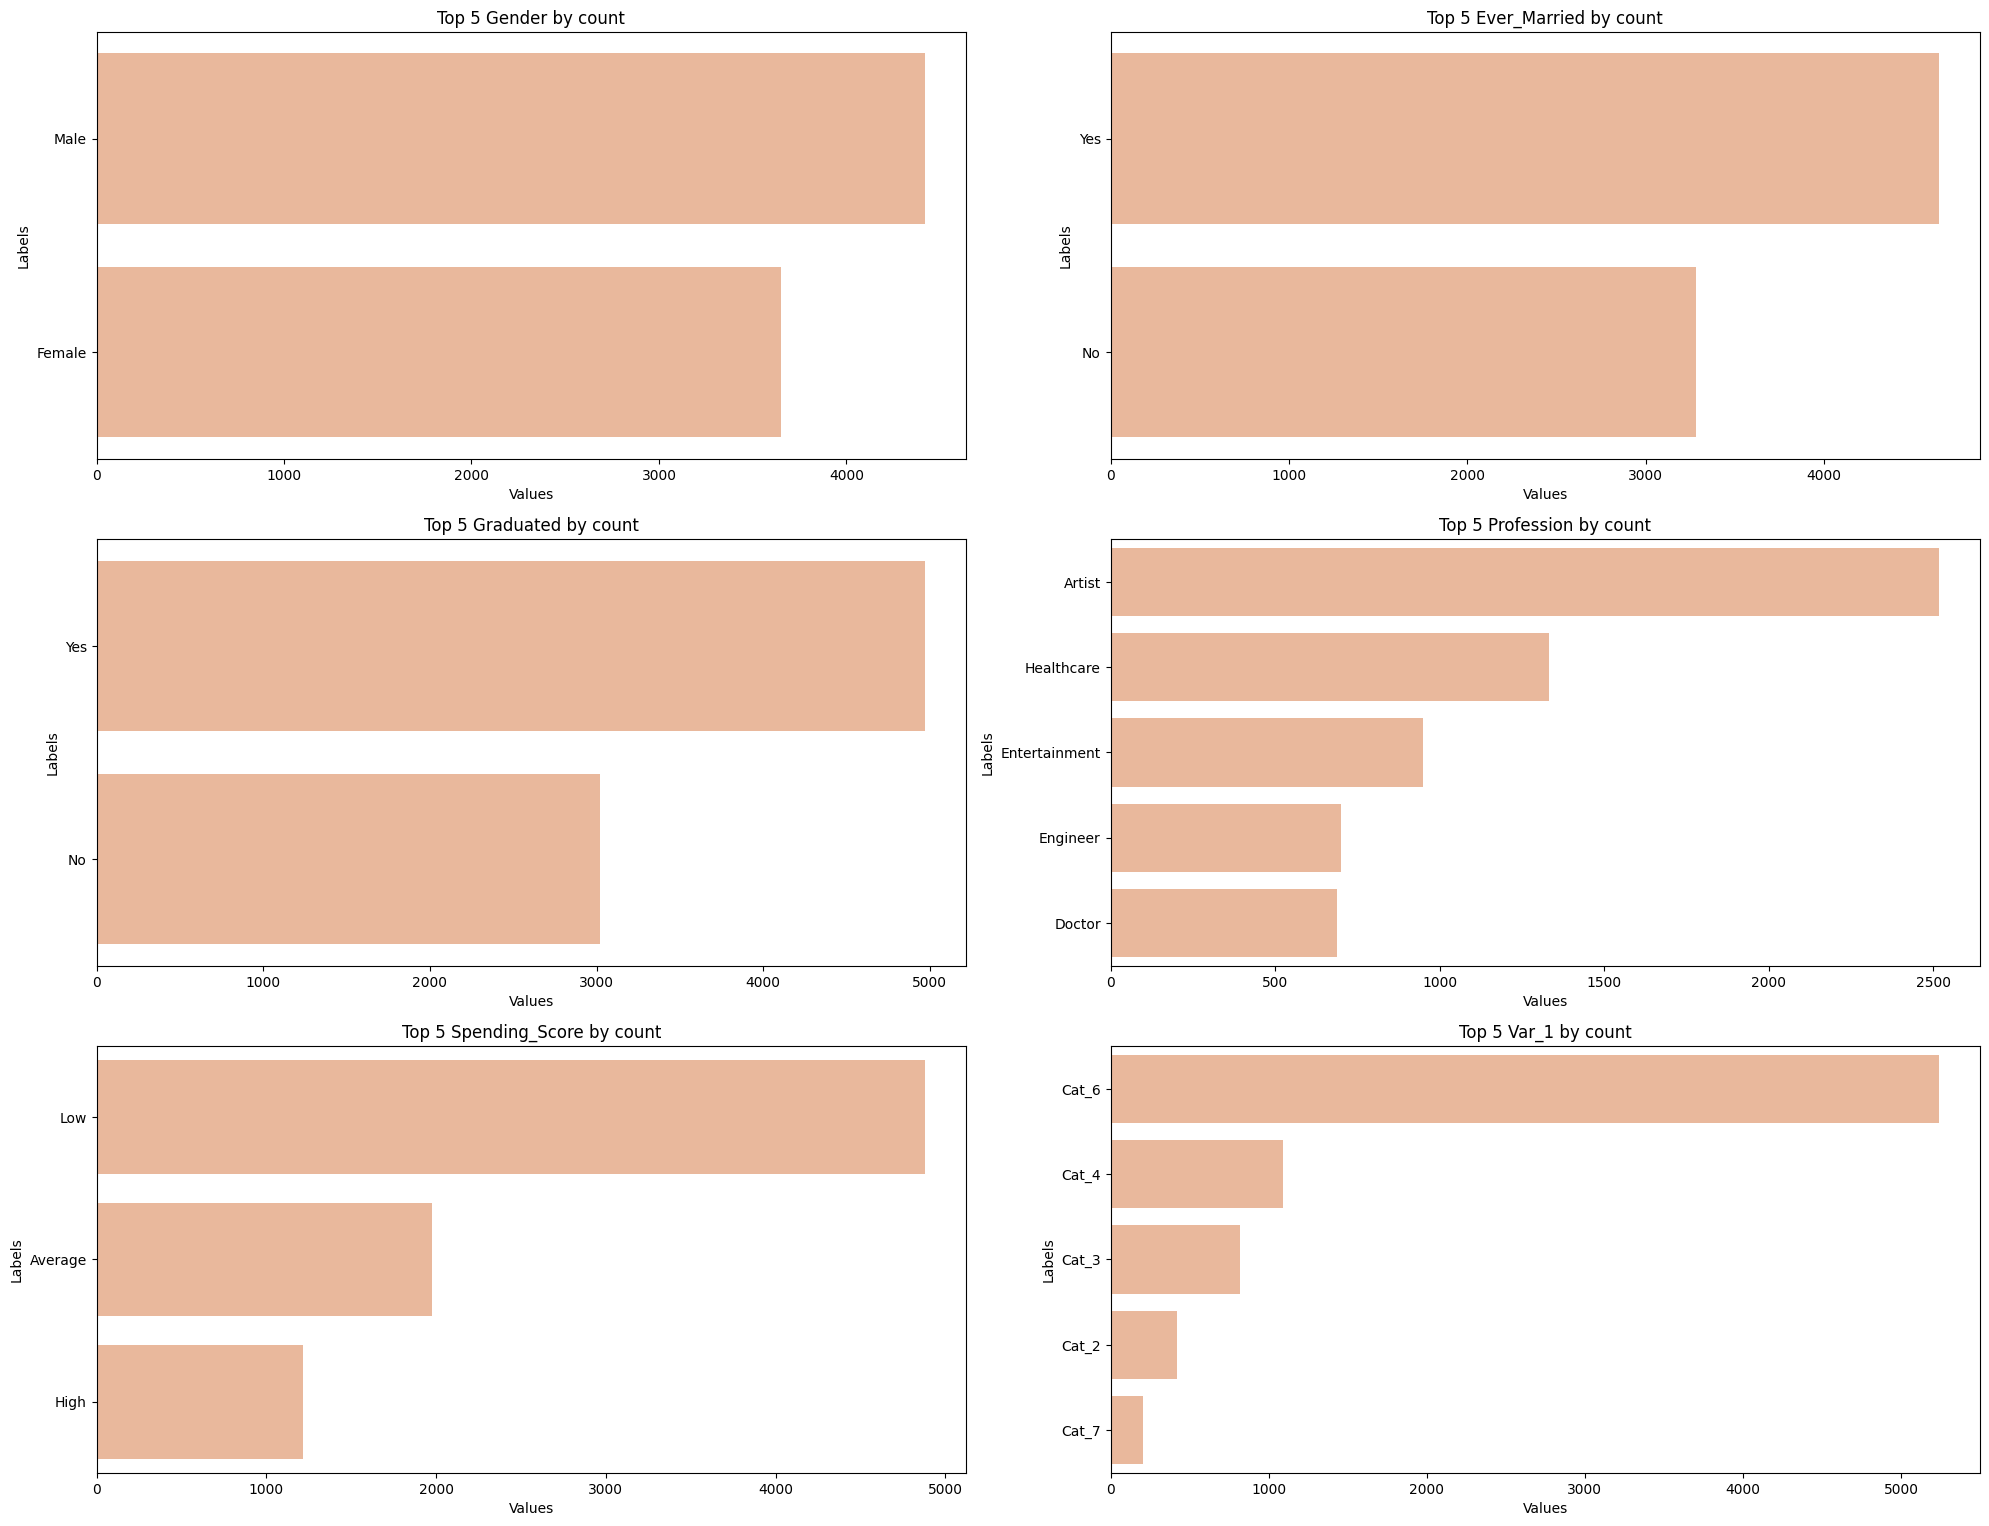

In [74]:
data_visualization.distribution_of_categorical_features()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

<Axes: >

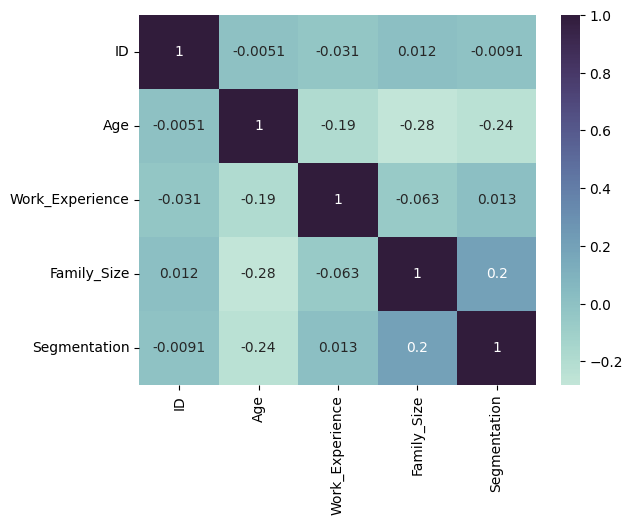

In [75]:
data_visualization.relation_numerical_feats_to_target_feat()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ tre

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:33: FutureWarning: Series.__getitem__ tre

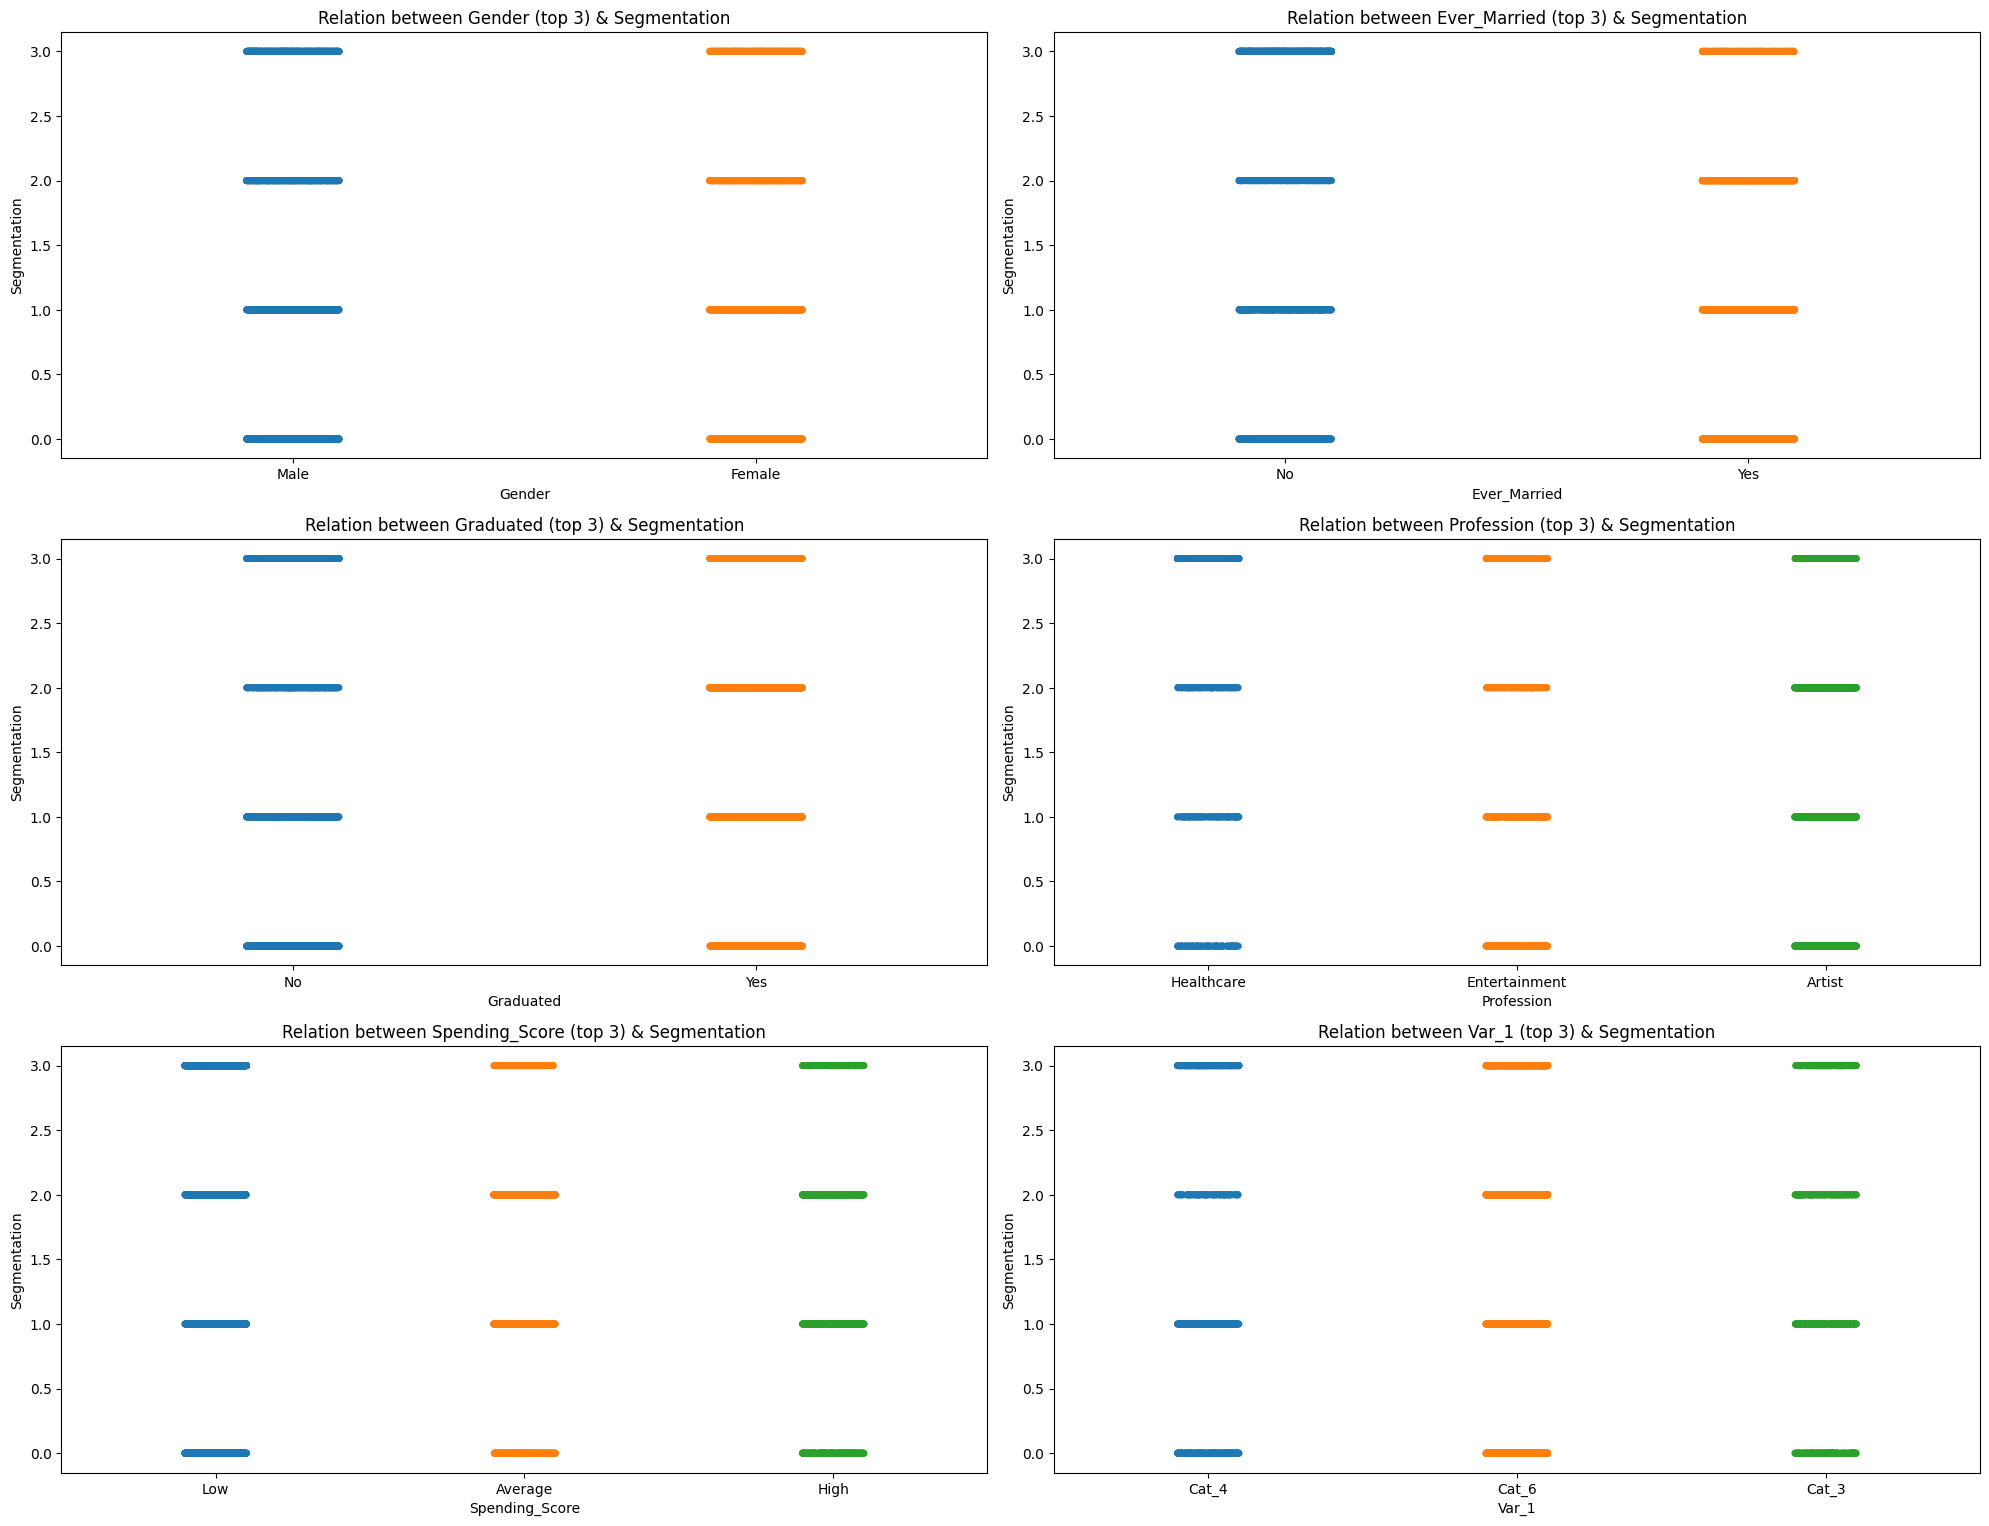

In [76]:
data_visualization.relation_categorical_feats_to_target_feat()

In [77]:
data_preprocessing = Data_Preprocessing(df,target_feature = target_feature)

X,y = data_preprocessing.transform()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

X_train = tf.constant(X_train)
y_train = tf.constant(y_train)

X_test = tf.constant(X_test)
y_test = tf.constant(y_test)

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27674/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

In [78]:
n_classes = len(eda.unique_values(target_feature))

model = Segmentation(n_classes)
Trainer = Train_Model(model,epochs = 100)

model = Trainer.fit(X_train,y_train)
Trainer.eval(X_test,y_test)

Unique values of Segmentation: [0 1 2 3]

Metrics on Train Data:
Epoch 1/100


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2600 - loss: 1.4370
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2554 - loss: 1.3903
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2603 - loss: 1.3873
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2792 - loss: 1.3853
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2886 - loss: 1.3791
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3487 - loss: 1.3551
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4272 - loss: 1.2720
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4613 - loss: 1.1819
Epoch 9/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4697 - loss: 1.1784
Epoch 10/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4804 - loss: 1.1703
Epoch 11/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4716 - loss: 1.1654
Epoch 12/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [80]:
Predict(model,X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array(['A', 'C', 'D', ..., 'B', 'D', 'A'], dtype='<U1')